# Introduction

This notebook analyse the interaction and the effects the different sociodemographics variables can have on the detection (or absence of detection) of disinformation and their impact on sharing the news.

## Import modules and functions

### Modules

In [1]:
# Import modules
import json
import csv
import itertools 

In [2]:
# Classic analysis imports
import numpy as np 
import pandas as pd 
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns

In [3]:
# Stat analysis import 
from sklearn import preprocessing
from sklearn.cluster import KMeans

import math

import scipy 
from scipy.stats import chi2_contingency
from scipy.stats import chi2

import scikit_posthocs as sp

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.stattools as stools
import statsmodels.stats as stats 
from statsmodels.graphics.regressionplots import *
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.anova import anova_lm
from statsmodels.stats import multicomp as mc
from statsmodels.miscmodels.ordinal_model import OrderedModel

import pingouin as pg

In [4]:
# options for the notebook
pd.set_option('display.max_colwidth',1000)
plt.style.use('seaborn')
sns.set_style('whitegrid')

### Functions

In [5]:
# Source: https://github.com/neuhofmo/chisq_test_wrapper

from scipy.stats import chi2_contingency
from statsmodels.sandbox.stats.multicomp import multipletests
from itertools import combinations


# This module contains functions that wrap the standard chi2_contingency test from scipy.stats.,
# as well as additional corrections for multiple comparisons and post-hoc tests.
# The usage is as simple as chisq_and_posthoc_corrected(df) 

# Uploaded by Moran Neuhof, 2018


def get_asterisks_for_pval(p_val, alpha=0.05):
    """Receives the p-value and returns asterisks string."""
    if p_val > alpha:  # bigger than alpha
        p_text = "ns"
    # following the standards in biological publications
    elif p_val < 1e-4:  
        p_text = '****'
    elif p_val < 1e-3:
        p_text = '***'
    elif p_val < 1e-2:
        p_text = '**'
    else:
        p_text = '*'
    
    return p_text  # string of asterisks


def run_chisq_on_combination(df, combinations_tuple):
    """Receives a dataframe and a combinations tuple and returns p-value after performing chisq test."""
    assert len(combinations_tuple) == 2, "Combinations tuple is too long! Should be of size 2."
    new_df = df[(df.index == combinations_tuple[0]) | (df.index == combinations_tuple[1])]
    chi2, p, dof, ex = chi2_contingency(new_df, correction=True)
    return p


def chisq_and_posthoc_corrected(df, correction_method='fdr_bh', alpha=0.05):
    """Receives a dataframe and performs chi2 test and then post hoc.
    Prints the p-values and corrected p-values (after FDR correction).
    alpha: optional threshold for rejection (default: 0.05)
    correction_method: method used for mutiple comparisons correction. (default: 'fdr_bh').
    See statsmodels.sandbox.stats.multicomp.multipletests for elaboration."""

    # start by running chi2 test on the matrix
    chi2, p, dof, ex = chi2_contingency(df, correction=True)
    print("Chi2 result of the contingency table: {}, p-value: {}\n".format(chi2, p))
    
    # post-hoc test
    all_combinations = list(combinations(df.index, 2))  # gathering all combinations for post-hoc chi2
    print("Post-hoc chi2 tests results:")
    p_vals = [run_chisq_on_combination(df, comb) for comb in all_combinations]  # a list of all p-values
    # the list is in the same order of all_combinations

    # correction for multiple testing
    reject_list, corrected_p_vals = multipletests(p_vals, method=correction_method, alpha=alpha)[:2]
    for p_val, corr_p_val, reject, comb in zip(p_vals, corrected_p_vals, reject_list, all_combinations):
        print("{}: p_value: {:5f}; corrected: {:5f} ({}) reject: {}".format(comb, p_val, corr_p_val, get_asterisks_for_pval(p_val, alpha), reject))
    return chi2, p, dof, ex


In [6]:
from scipy.stats import chi2_contingency
from scipy.stats import norm
def chisq_posthoc_corrected(cross_table, correction_method='bonferroni', alpha=.05):
    """
    Get crosstab dataframe and do a chisquared test followed with the post-hoc with analysis of adjusted residuals
    source: https://colab.research.google.com/drive/1QIDHMvpDq7Max5hk2mozSFdVssavdV-I#scrollTo=ig1kdg40qLDH
    source: https://github.com/neuhofmo/chisq_test_wrapper
    """
    def get_asterisks_for_pval(p_val, alpha=0.05):
        """Receives the p-value and returns asterisks string."""
        if p_val > alpha:  # bigger than alpha
            p_text = "ns"
        # following the standards in biological publications
        elif p_val < 1e-4:  
            p_text = '****'
        elif p_val < 1e-3:
            p_text = '***'
        elif p_val < 1e-2:
            p_text = '**'
        else:
            p_text = '*'
    
        return p_text  # string of asterisks
    
    chiVal, pVal, df, exp = chi2_contingency(cross_table)
    print("Chi2 result of the contingency table: {}, p-value: {}\n".format(chiVal, pVal))

    colTotals = cross_table.sum()
    nCols = len(colTotals)
    rowTotals = cross_table.sum(axis=1)
    nRows = len(rowTotals)
    n = sum(rowTotals)
    
    
    for i in range(nRows):
        for j in range(nCols):
            AdjRes = (cross_table.iloc[i,j] - exp[i,j]) / (exp[i,j]*(1-rowTotals[i]/n)*(1-colTotals[j]/n))**0.5            
    phRes = pd.DataFrame(columns=[cross_table.index.name, cross_table.columns.name, 'Adj. Res.'])
    for i in range(nRows):
        for j in range(nCols):
            AdjRes = (cross_table.iloc[i,j] - exp[i,j]) / (exp[i,j]*(1-rowTotals[i]/n)*(1-colTotals[j]/n))**0.5
            phRes = phRes.append({cross_table.index.name:cross_table.index[i], cross_table.columns.name:cross_table.columns[j], 'Adj. Res.':AdjRes}, ignore_index=True)
    phRes['p_value'] = 2*(1-norm.cdf(abs(phRes['Adj. Res.'])))
    # Bonferroni correction
  
    reject_list, corrected_p_vals = multipletests(phRes['p_value'], method=correction_method, alpha=alpha)[:2]
    
    phRes['p_value_corrected'] = corrected_p_vals
    phRes['reject'] = reject_list
    ast = []
    for p_vals in corrected_p_vals:
        ast.append(get_asterisks_for_pval(p_vals))
    phRes['asterisques'] = ast

    return phRes


In [7]:
# Functions
def heatmap(data, row_labels, col_labels, ax=None, cbar=False,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    if cbar is True:
        cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    else:
        cbar = None

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mp.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


## Data

### Loading

In [8]:
# Setting up the folders 
data_folder = "../data/"
analysis_results_folder = "../results/"
plots_folders = "../plots"

# Filenames
dataset_filename = 'sondea_analisis_20210323_SONDEA.csv'

In [9]:
df_raw = pd.read_csv('{}{}'.format(data_folder, dataset_filename),  sep=';')

In [10]:
for col in df_raw.columns:
    print('{} - Unique var: {}'.format(col, len(df_raw[col].unique())))

    print(df_raw[col].value_counts().head(8))
    print('\n')

fake_news - Unique var: 10
Stefano Montario: las mascarillas incuban el cáncer                                                                              128
El uso prolongado del tapaboca produce hipoxia                                                                                   119
La OMS alerta sobre el Virus Nipah, que puede ser peor que el Covid-19                                                           115
Bill Gates anuncia que implantará microchips para combatir Covid-19 y rastrear las vacunas                                       107
Hantavirus. La OMS advierte al mundo del nuevo virus que viene de China                                                          107
El Ministerio del Interior alemán define al coronavirus como "falsa alarma global" en un informe filtrado a la prensa            105
Madrid denuncia que el Gobierno paralizó en Zaragoza 5.000 kilos de mascarillas para Madrid porque "Aduanas cierra a las 15h"    104
Alimentos que más inmunizan contra el coro

In [11]:
# convert to datetime columns to type datetime
df_raw['dt_arrive'] = pd.to_datetime(df_raw['date_arrive'])
df_raw['dt_finish'] = pd.to_datetime(df_raw['date_finish'])

# create a new variable to store time completion (in minutes)
df_raw['time_completion_min'] = df_raw.apply(lambda row: round((row['dt_finish'] - row['dt_arrive']).seconds/60,3), axis=1)

#df_raw['dm_lugar'] = df_raw.apply(lambda row: row['dm_provincia'] if row['dm_provincia'] != 'Fuera de España' else unicodedata.normalize('NFD', row['dm_prov_otro'].strip().title()).encode('ascii', 'ignore').decode(), axis=1)
df_raw['dm_lugar_country'] = df_raw.apply(lambda row: row['dm_prov_otro'] if row['dm_provincia'] == 'Fuera de España' else 'España', axis=1)
#TODO [CCAA]

df_raw['dm_employment'] = df_raw.apply(lambda row: row['dm_empleo'] if row['dm_empleo'] != 'Otro' else row['dm_empleo_otro'].strip().title(), axis=1)


### Recode True - Fake news 

In [12]:
# Recode the True - False and Fake news

df_raw = df_raw.rename(columns={'tysno_verdadera': 'True news', 'fysno_verdadera': "Fake news"})

# Recode the Si and No into Right and Wrong to avoid confusion
df_raw['True news'] = df_raw['True news'].replace({'sí': 'Right'})
df_raw['True news'] = df_raw['True news'].replace({'no': 'Wrong'})

df_raw['Fake news'] = df_raw['Fake news'].replace({'sí': 'Wrong'})
df_raw['Fake news'] = df_raw['Fake news'].replace({'no': 'Right'})
df_raw['Fake news'].value_counts()

Right    679
Wrong    384
Name: Fake news, dtype: int64

### Create count_error 

In [13]:
# Get the number of error per profile
df_raw['count_error'] = (df_raw[['True news', 'Fake news']]=="Wrong").sum(axis="columns")
df_raw['count_error'].value_counts()

df_raw = df_raw.astype({'count_error': 'category'})
# Transform the count errors into category type
df_raw.count_error.replace({0: 'No error', 1:'1 error', 2:'2 errors'}, inplace=True)



df_raw.count_error = pd.Categorical(df_raw.count_error, categories=['No error', '1 error', '2 errors'],ordered=True)
df_raw.count_error

0        1 error
1       2 errors
2        1 error
3        1 error
4        1 error
          ...   
1058    No error
1059    No error
1060     1 error
1061    2 errors
1062     1 error
Name: count_error, Length: 1063, dtype: category
Categories (3, object): ['No error' < '1 error' < '2 errors']

### Recode religion

In [14]:
# Recode religion into believers, atheist, agnostic

## Get the value of Otro in dm_pref_religion
df_raw['dm_pref_religion'] = df_raw.apply(lambda row: row['dm_religion'] if row['dm_religion'] != 'Otro' else row['dm_rel_otro'].strip().title(), axis=1)


## Recode the different entries into believers-atheist/agnostics
believers = ['Católico', 'Islámico', 'Evangélico', 'Protestante', 'Budista', 'Cristiano', 'Protestante', 
             'Musulmán', 'Grigoriano Apostolico', 'Soy Cristiana', 'Católica No Practicante', 'Testigo De Jehová', 
             'Católico Pero No Acudo A Misa', 'Soy Cristiano, Creo En Dios', 'Católico No Practicante',
             'Es Largo De Explicar , Es Una Iglesia Moderna', 'Creo En Las Ciencias Ocultas Y La Espiritualidad',
             'Creo En Dios A Través De Jesucristo',
             'Sincretismo Pragmático', 'Creo En Dios A Través De Jesucristo.', 'Ortodoxo']

non_believer_atheist = ['Agnóstico', 'Soy Agnóstico', 'Ateo', 'Ningún Punto Religioso..Creo En La Vida.', 'Ni Creo Ni Dejo De Creer' ]

df_raw['recode_religion'] = df_raw['dm_pref_religion'].replace(believers, 'Believers')
df_raw['recode_religion'] = df_raw['recode_religion'].replace(non_believer_atheist, 'Atheists/Agnostics')
# Code as None if not within these two categories
df_raw['recode_religion'] = np.where(df_raw['recode_religion'].isin(['Believers','Atheists/Agnostics']), df_raw['recode_religion'], None)
df_raw['recode_religion'].value_counts()

Believers             555
Atheists/Agnostics    404
Name: recode_religion, dtype: int64

### Recode politics

In [15]:
# aggregate politics preferences into bigger groups (izquierda, derecha, centro)
def aggregate_politics(val):
    if val in ['Izquierda', 'Centro izquierda']:
        return 'Izquierda'
    elif val in ['Derecha', 'Centro derecha']:
        return 'Derecha'
    elif val == 'Centro':
        return val
    else:
        return None
df_raw['recode_politics'] = df_raw['dm_politica'].apply(aggregate_politics)
df_raw['recode_politics'].value_counts()

Izquierda    442
Derecha      208
Centro       180
Name: recode_politics, dtype: int64

### Recode age

In [16]:
# aggregate ages into bigger groups (18-34, 35-54, >54)
def aggregate_age(val):
    if val in ['< 18 años', '18-24 años', '25-34 años']:
        return '<=18-34'
    elif val in ['35-44 años', '45-54 años']:
        return '35-54'
    elif val in ['55-65 años', '> 65 años']:
        return '>55'
    elif val is None:
        return None
df_raw['recode_age'] = df_raw.dm_edad.apply(aggregate_age)

df_raw.recode_age = pd.Categorical(df_raw.recode_age, categories=['<=18-34', '35-54', '>55'],ordered=True)


df_raw.recode_age.value_counts()

35-54      549
<=18-34    258
>55        256
Name: recode_age, dtype: int64

### Recode education

In [17]:
# Recode education
df_raw['dm_education'] = df_raw.apply(lambda row: row['dm_educacion'] if row['dm_educacion'] != 'Otro' else row['dm_edu_otro'].strip().title(), axis=1)


#education_recoded_values = ['Primaria', 'Secundaria', 'Formación Profesional', 'Grado/Licenciatura', 'Master', 'Posgrado', 'Doctorado' ]

# Code as None if not within the list of education level
#df_raw['recode_education'] = np.where(df_raw['dm_education'].isin(education_recoded_values), df_raw['dm_education'], None)


# Recode education into broader categories
uni = ['Posgrado', 'Doctorado', 'Master', 'Grado/Licenciatura' ]
non_uni = ['No tiene estudios en educación formal', 'Formación Profesional', 'Primaria', 'Secundaria', 'Cou', 'Bachillerato']




df_raw['recode_education'] = df_raw['dm_education'].replace(uni, 'University studies')
df_raw['recode_education'] = df_raw['recode_education'].replace(non_uni, 'No university studies')



# Alternative recoding
up_to_secondaria = ['Primaria', 'Secundaria', 'No tiene estudios en educación formal']
up_to_bac_3 = ['Formación Profesional', 'Grado/Licenciatura', 'Bachillerato']
up_to_university_level = ['Master','Posgrado', 'Doctorado']


# Code as None if not within these categories
df_raw['recode_education'] = np.where(df_raw['recode_education'].isin(['University studies', 'No university studies']), df_raw['recode_education'], None)
df_raw.recode_education.value_counts()

University studies       559
No university studies    502
Name: recode_education, dtype: int64

In [18]:
df_raw['dm_education'].value_counts()

Grado/Licenciatura                       382
Formación Profesional                    305
Secundaria                               167
Master                                   109
Posgrado                                  45
Primaria                                  27
Doctorado                                 23
NS/NC                                      2
Bachillerato                               1
No tiene estudios en educación formal      1
Cou                                        1
Name: dm_education, dtype: int64

### Recode actions


In [19]:
# faf and taf are questions asked if the subject answer 'True' to the news in case of True and Fake news. 
# The faf will then for people who were wrong and the taf for people who were rignt
var_actions_f = ['faf_compartira_familia_amigos', 'faf_publicara_redes', 'faf_consultara_fuentes', 'faf_aplicara_aprendido', 'faf_no_accion']
var_actions_t = ['taf_compartira_familia_amigos', 'taf_publicara_redes', 'taf_consultara_fuentes', 'taf_aplicara_aprendido', 'taf_no_accion']
var_actions = var_actions_f + var_actions_t
df_raw.loc[:, var_actions] = df_raw.loc[:, var_actions].replace({'checked': True, 'unchecked': False})
df_raw.loc[:, var_actions].value_counts()

faf_compartira_familia_amigos  faf_publicara_redes  faf_consultara_fuentes  faf_aplicara_aprendido  faf_no_accion  taf_compartira_familia_amigos  taf_publicara_redes  taf_consultara_fuentes  taf_aplicara_aprendido  taf_no_accion
False                          False                False                   False                   True           False                          False                False                   False                   True             373
                                                    True                    False                   False          False                          False                True                    False                   False            144
True                           False                False                   False                   False          True                           False                False                   False                   False             69
False                          False                False      

In [20]:
# In case the subject thinks it is a True News (regardless of the news)
var_justifications_True = ['tys_recuerda_leida',
'tys_medio_comunicacion_conocido',
'tys_medio_comunicacion_fiable',
'tys_fuentes_conocidas',
'tys_fuentes_confiables',
'tys_abordaje_serio',
'tys_coherente',
'tys_concuerda_creencias',
'tys_alineado_ideologia',
'tys_otro']

# In case the subject thinks it is a Fake News (regardless of the news)
var_justification_Wrong = ['tno_aclaracion_desmintiendo',
'tno_medio_desconocido',
'tno_medio_poco_fiable',
'tno_fuentes_desconocidas',
'tno_fuentes_no_confiables',
'tno_sin_fuentes',
'tno_abordaje_no_serio',
'tno_no_coherente',
'tno_titulo_sensacionalista',
'tno_imagen_sensacionalista',
'tno_no_concuerda_creencias',
'tno_no_alineado_ideologia',
'tno_otro']

### Recode NS into Np.NaN
It seems the NS/NC is equal to None

In [21]:
df_raw = df_raw.replace('NS/NC', np.nan)

### Filtering the data

In [22]:
# #FIXME The date_finish is never None. Therefore that datapoint is not relevant. 
fin = ~df_raw['date_finish'].isnull() # finished experiments
ini = df_raw['time_index']>0          # initiated or read news 1
read_only_1 = ini & (df_raw['time_news1']==0) # read only 1 news
read_both = df_raw['time_news1']>0    # read both news
got_to_ans = df_raw['time_news2']>0    # read both news and got to ans

To decide which data are considered as completed, the time to reach time_news2 is use and it is 

In [23]:
# Filtering
df_all = df_raw
df_init = df_raw[ini]
df = df_raw[got_to_ans]

print('Size of the filtered sample: {}'.format(df.shape[0]))

Size of the filtered sample: 910


Text(0.5, 1.0, 'Frecuencia de usuarios por estado')

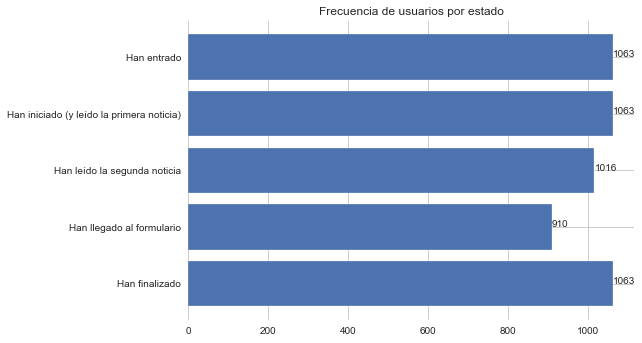

In [24]:
y = ['Han entrado','Han iniciado (y leído la primera noticia)','Han leído la segunda noticia', 'Han llegado al formulario', 'Han finalizado']
x = [df_all.shape[0], df_all[ini].shape[0], df_all[read_both].shape[0], df_all[got_to_ans].shape[0], df_all[fin].shape[0]]
plt.barh(y, x)
for index, value in enumerate(y):
    plt.text(x[index], index, str(x[index]))

plt.gca().invert_yaxis()
plt.title('Frecuencia de usuarios por estado')

The column `Han finalizado` is inconsistent with the other counts. After inspection it is because there is no `None` value for that variable.

In [25]:
df = df_raw[got_to_ans]

print('Size of the filtered sample: {}'.format(df.shape[0]))

Size of the filtered sample: 910


Estadisticas descriptivas de tiempo de completitud del experimento (minutos)



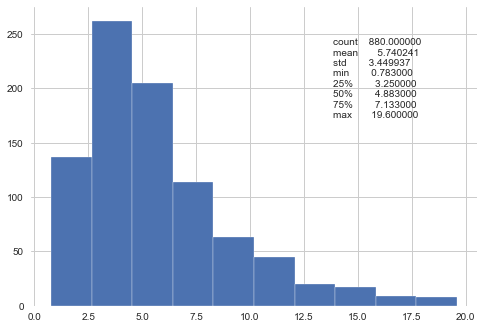

In [26]:
# df[df['time_completion_min']<=20]['time_completion_min'].plot.hist()
fig, ax = plt.subplots()
ax.hist(df[df['time_completion_min']<=20]['time_completion_min'])
plt.figtext(0.65,0.6, df[df['time_completion_min']<=20]['time_completion_min'].describe().to_string())
print("Estadisticas descriptivas de tiempo de completitud del experimento (minutos)\n")

In [27]:
# Removing the subjects that answer in less or equal to 1 minutes to be sure we get subject that get focused. 

In [28]:
df[df['time_completion_min'] <= 1]['time_completion_min'].count()

6

In [29]:
df = df[df['time_completion_min'] > 1]
print('Size of the final filtered sample: {}'.format(df.shape[0]))

Size of the final filtered sample: 904


The time for completion does not show any outliers, therefore all can be included

# Analysis

## Difference in getting wrong for True News and Fake News

### Data 

In [30]:
true_fake_r_w = df[['True news', 'Fake news']].unstack().reset_index().drop(columns=['level_1'])
true_fake_r_w.columns = ['Type of news', 'Answer']
true_fake_r_w_cont = pd.crosstab(true_fake_r_w['Type of news'], true_fake_r_w['Answer'])
true_fake_r_w_cont

Answer,Right,Wrong
Type of news,,
Fake news,574,330
True news,610,294


### Heatmap

<AxesSubplot:xlabel='Answer', ylabel='Type of news'>

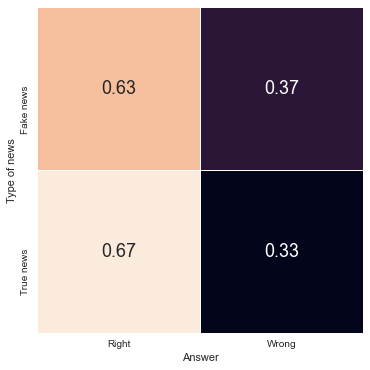

In [31]:
# Create the normalised version for the heatmap
true_fake_r_w_cont_normalised = pd.crosstab(true_fake_r_w['Type of news'], true_fake_r_w['Answer'], normalize='index')
true_fake_r_w_cont_normalised

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(true_fake_r_w_cont_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)

### Barplot

In [32]:
data_bar_plot = true_fake_r_w.value_counts().to_frame().rename(columns={0:'count'}).reset_index()

<AxesSubplot:xlabel='Answer', ylabel='count'>

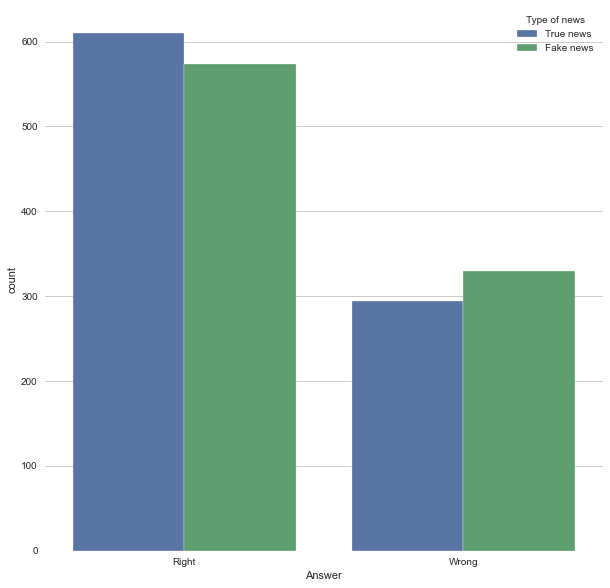

In [33]:
f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(hue="Type of news", y="count", x="Answer",  data=data_bar_plot, ax=ax)

### Chi-Square

In [34]:
data_chi_square = chisq_and_posthoc_corrected(true_fake_r_w_cont)

Chi2 result of the contingency table: 2.9977694040194036, p-value: 0.08337923995611544

Post-hoc chi2 tests results:
('Fake news', 'True news'): p_value: 0.083379; corrected: 0.083379 (ns) reject: False


## Number of people per number of mistakes

In [35]:
data = df['count_error'].value_counts().to_frame().reset_index()
#data['index'] = pd.Categorical(data['index'], categories=['No error', '1 error', '2 errors'],ordered=True)
data = data.sort_values(by=['index', 'count_error'])
data['count_expected'] = [0.25*data.sum().values[0], 0.5*data.sum().values[0], 0.25*data.sum().values[0]]


### Barplot

<AxesSubplot:xlabel='index', ylabel='count_expected'>

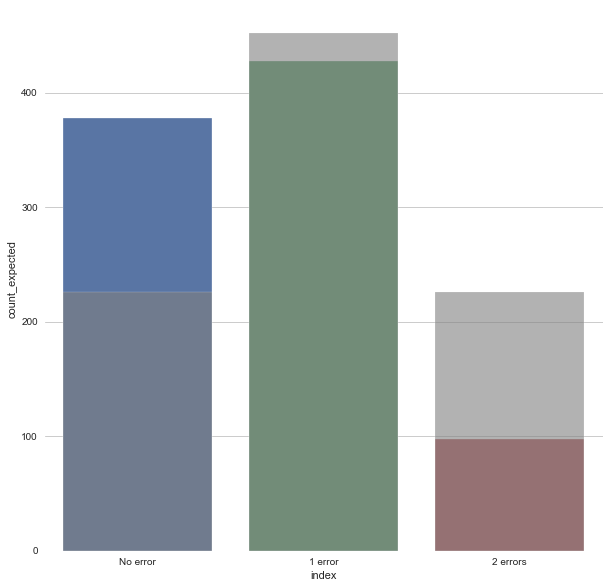

In [36]:
f, ax = plt.subplots(figsize=(10, 10))

sns.barplot( y="count_error", x="index",  data=data, ax=ax, alpha=1)
sns.barplot( y="count_expected", x="index",  data=data, ax=ax, alpha=0.6, color='grey')

### Goodness of fit

In [37]:
# TODO analysis of where

In [38]:
stats.gof.chisquare(f_obs= data['count_error'], f_exp=data['count_expected'], return_basic=False)

(176.0, 6.054601895401188e-39)

The distribution of the sample is different than the expected distribution

# Independence

## Difference for being better informed with the age

In [39]:
col_var = 'recode_age'
data = df[[col_var, 'count_error']]
# Drop the na
data = data.dropna()
n_ = len(data)

data_count = pd.crosstab(data[col_var], data['count_error'])

data_count

count_error,No error,1 error,2 errors
recode_age,,,
<=18-34,95,106,26
35-54,188,212,53
>55,95,110,19


In [40]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 904


In [41]:
data_count_normalised = pd.crosstab(  df[col_var],df['count_error'], normalize='index')
data_count_normalised

count_error,No error,1 error,2 errors
recode_age,,,
<=18-34,0.418502,0.466960,0.114537
35-54,0.415011,0.467991,0.116998
>55,0.424107,0.491071,0.084821


### Heatmap

<AxesSubplot:xlabel='count_error', ylabel='recode_age'>

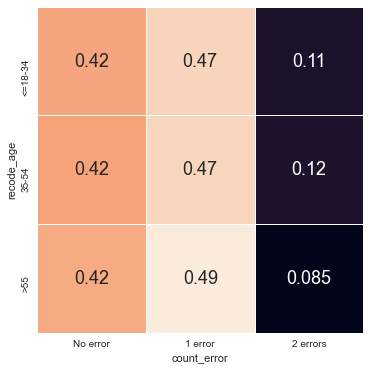

In [42]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)

### Barplot

In [43]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_age,count_error,count
0,35-54,1 error,212
1,35-54,No error,188
2,>55,1 error,110
3,<=18-34,1 error,106
4,<=18-34,No error,95
5,>55,No error,95
6,35-54,2 errors,53
7,<=18-34,2 errors,26
8,>55,2 errors,19


<AxesSubplot:xlabel='count_error', ylabel='count'>

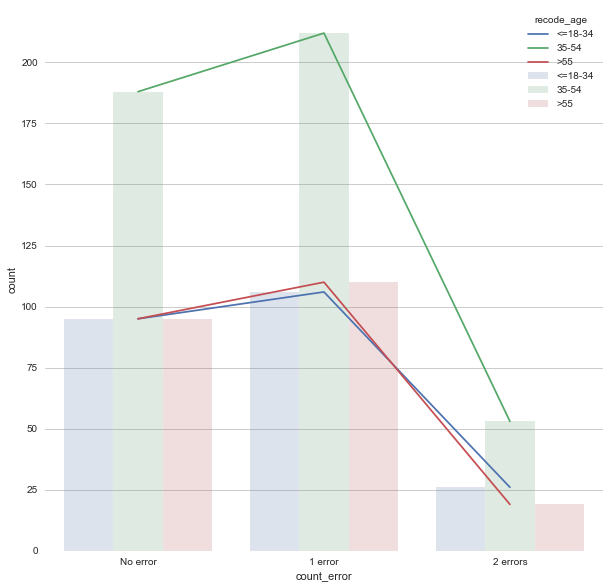

In [44]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax, alpha=0.2)

### Kruskal-Wallis H test

In [45]:
value_per_grp = data.groupby(col_var)['count_error'].apply(list)

In [46]:
scipy.stats.kruskal(*value_per_grp)

KruskalResult(statistic=0.05835464736065558, pvalue=0.9712442245955498)

### Post-hoc: Dunn test

In [47]:
sp.posthoc_dunn(data, val_col='count_error', group_col=col_var, p_adjust = 'bonferroni')

,<=18-34,35-54,>55
<=18-34,1.0,1.0,1.0
35-54,1.0,1.0,1.0
>55,1.0,1.0,1.0


There is no difference due to age in getting more or less errors

## Difference due to gender

In [48]:
col_var = 'dm_genero'
data = df[[col_var, 'count_error']]
# Drop Np.NaN
data = data.dropna()

n_ = len(data)

data_count = pd.crosstab(data[col_var], data['count_error'])

data_count

count_error,No error,1 error,2 errors
dm_genero,,,
Femenino,210,223,49
Masculino,168,205,49


In [49]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 904


In [50]:
data_count_normalised = pd.crosstab(  df[col_var],df['count_error'], normalize='index')
data_count_normalised

count_error,No error,1 error,2 errors
dm_genero,,,
Femenino,0.435685,0.462656,0.101660
Masculino,0.398104,0.485782,0.116114


### Heatmap

<AxesSubplot:xlabel='count_error', ylabel='dm_genero'>

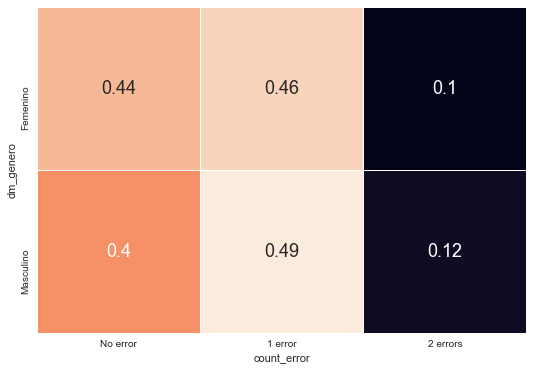

In [51]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)

### Barplot

In [52]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,dm_genero,count_error,count
0,Femenino,1 error,223
1,Femenino,No error,210
2,Masculino,1 error,205
3,Masculino,No error,168
4,Femenino,2 errors,49
5,Masculino,2 errors,49


<AxesSubplot:xlabel='count_error', ylabel='count'>

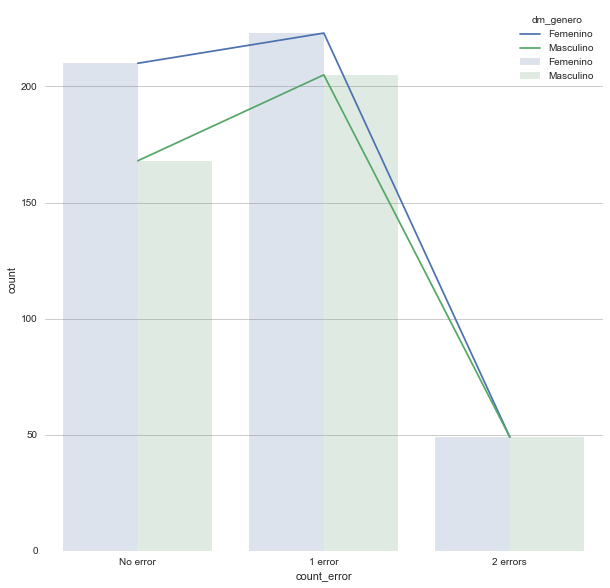

In [53]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax, alpha=0.2)

### Wilcoxon-Mann-Whitney test 

In [54]:
#data = df[['recode_education', 'count_error']]
# Drop the non-binary (only 2 in it, cannot perform test)
# No nee tyo drop them, not in the dataset
# Recode the age into numerical value
data.loc[:, 'count_error'] = data.loc[:, 'count_error'].replace({"No error": 0, '1 error': 1, '2 errors': 2})

In [55]:
value_per_grp = data.groupby(col_var)['count_error'].apply(list)

In [56]:
pg.mwu(*value_per_grp, tail='two-sided')

,U-val,tail,p-val,RBC,CLES
MWU,97439.0,two-sided,0.229284,0.041917,0.479042


## Difference due to Uni - None Uni

In [57]:
col_var = 'recode_education'
data = df[[col_var, 'count_error']]
# Drop the na
data = data.dropna()
n_ = len(data)

data_count = pd.crosstab(data[col_var], data['count_error'])

data_count

count_error,No error,1 error,2 errors
recode_education,,,
No university studies,148,220,50
University studies,229,207,48


In [58]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 902


In [59]:
data_count_normalised = pd.crosstab(  df[col_var],df['count_error'], normalize='index')
data_count_normalised

count_error,No error,1 error,2 errors
recode_education,,,
No university studies,0.354067,0.526316,0.119617
University studies,0.473140,0.427686,0.099174


### Heatmap

<AxesSubplot:xlabel='count_error', ylabel='recode_education'>

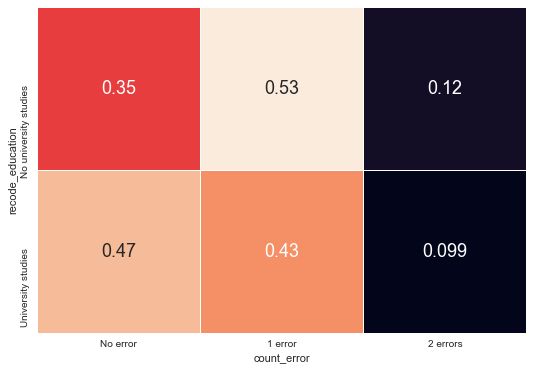

In [60]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)

### Barplot

In [61]:
data_bar_plot = df[['count_error', col_var]].value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,count_error,recode_education,count
0,No error,University studies,229
1,1 error,No university studies,220
2,1 error,University studies,207
3,No error,No university studies,148
4,2 errors,No university studies,50
5,2 errors,University studies,48


<AxesSubplot:xlabel='count_error', ylabel='count'>

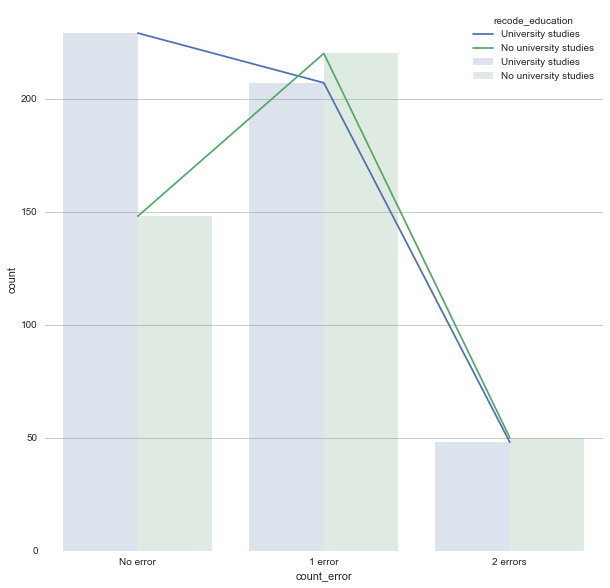

In [62]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax, alpha=0.2)

### Wilcoxon-Mann-Whitney test

In [63]:
#data = df[['recode_education', 'count_error']]
# Drop the non-binary (only 2 in it, cannot perform test)
# No nee tyo drop them, not in the dataset
# Recode the age into numerical value
data.loc[:, 'count_error'] = data.loc[:, 'count_error'].replace({"No error": 0, '1 error': 1, '2 errors': 2})

In [64]:
value_per_grp = data.groupby(col_var)['count_error'].apply(list)

In [65]:
pg.mwu(*value_per_grp, tail='two-sided')

,U-val,tail,p-val,RBC,CLES
MWU,113096.0,two-sided,0.000725,-0.118036,0.559018


## Difference with the political parties

In [66]:
col_var = 'recode_politics'
data = df[[col_var, 'count_error']]
# Drop Np.NaN
data = data.dropna()

n_ = len(data)

data_count = pd.crosstab(data[col_var], data['count_error'])

data_count

count_error,No error,1 error,2 errors
recode_politics,,,
Centro,49,85,14
Derecha,63,89,26
Izquierda,184,149,43


In [67]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 702


In [68]:
data_count_normalised = pd.crosstab(  df[col_var],df['count_error'], normalize='index')
data_count_normalised

count_error,No error,1 error,2 errors
recode_politics,,,
Centro,0.331081,0.574324,0.094595
Derecha,0.353933,0.500000,0.146067
Izquierda,0.489362,0.396277,0.114362


### Heatmap

<AxesSubplot:xlabel='count_error', ylabel='recode_politics'>

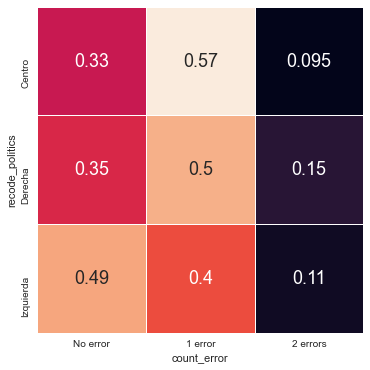

In [69]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)

### Barplot

In [70]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_politics,count_error,count
0,Izquierda,No error,184
1,Izquierda,1 error,149
2,Derecha,1 error,89
3,Centro,1 error,85
4,Derecha,No error,63
5,Centro,No error,49
6,Izquierda,2 errors,43
7,Derecha,2 errors,26
8,Centro,2 errors,14


<AxesSubplot:xlabel='count_error', ylabel='count'>

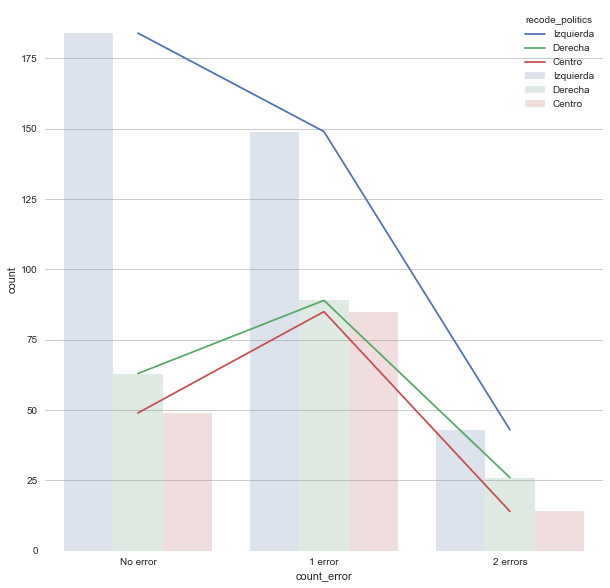

In [71]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax, alpha=0.2)

### Kruskal-Wallis H test

In [72]:
value_per_grp = data.groupby(col_var)['count_error'].apply(list)

In [73]:
scipy.stats.kruskal(*value_per_grp)

KruskalResult(statistic=16.75064879244889, pvalue=0.00023048508697181744)

### Post-hoc: Dunn test

In [74]:
sp.posthoc_dunn(data, val_col='count_error', group_col=col_var, p_adjust = 'bonferroni')

,Centro,Derecha,Izquierda
Centro,1.000000,1.000000,0.035736
Derecha,1.000000,1.000000,0.011798
Izquierda,0.035736,0.011798,1.000000


## Difference with the religious believes

In [75]:
col_var = 'recode_religion'
data = df[[col_var, 'count_error']]
# Drop the na
data = data.dropna()
n_ = len(data)

data_count = pd.crosstab(data[col_var], data['count_error'])

data_count

count_error,No error,1 error,2 errors
recode_religion,,,
Atheists/Agnostics,179,142,32
Believers,160,240,59


In [76]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 812


In [77]:
data_count_normalised = pd.crosstab(  df[col_var],df['count_error'], normalize='index')
data_count_normalised

count_error,No error,1 error,2 errors
recode_religion,,,
Atheists/Agnostics,0.507082,0.402266,0.090652
Believers,0.348584,0.522876,0.128540


### Heatmap

<AxesSubplot:xlabel='count_error', ylabel='recode_religion'>

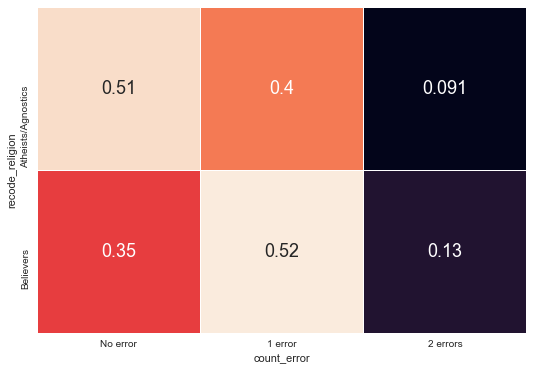

In [78]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)

### Barplot

In [79]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_religion,count_error,count
0,Believers,1 error,240
1,Atheists/Agnostics,No error,179
2,Believers,No error,160
3,Atheists/Agnostics,1 error,142
4,Believers,2 errors,59
5,Atheists/Agnostics,2 errors,32


<AxesSubplot:xlabel='count_error', ylabel='count'>

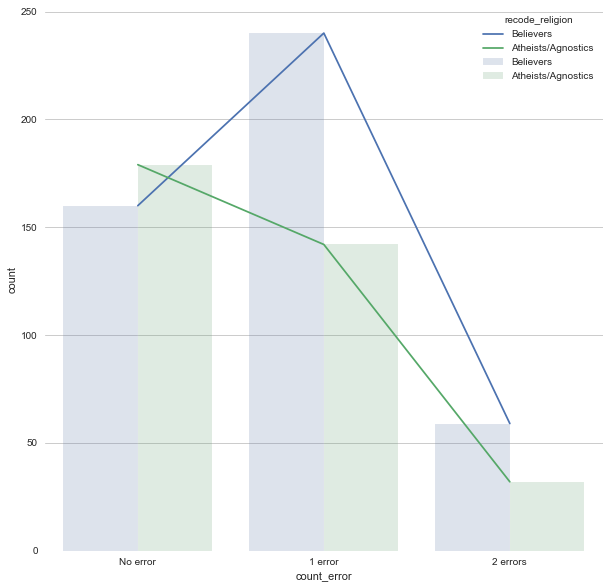

In [80]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax, alpha=0.2)

### Wilcoxon-Mann-Whitney test 

In [81]:
#data = df[['recode_education', 'count_error']]
# Drop the non-binary (only 2 in it, cannot perform test)
# No nee tyo drop them, not in the dataset
# Recode the age into numerical value
data['count_error'].replace({"No error": 0, '1 error': 1, '2 errors': 2}, inplace=True)

In [82]:
value_per_grp = data.groupby(col_var)['count_error'].apply(list)

In [83]:
pg.mwu(*value_per_grp, tail='two-sided')

,U-val,tail,p-val,RBC,CLES
MWU,67824.0,two-sided,0.000011,0.162806,0.418597


## Difference due to level of technology knowledge

In [84]:
col_var = 'dm_tecnologia'
data = df[[col_var, 'count_error']]
# Drop the NS/NC
data= data[data[col_var] != 'NS/NC']
# Drop the na
data = data.dropna()

n_ = len(data)

data_count = pd.crosstab(data[col_var], data['count_error'])

data_count

count_error,No error,1 error,2 errors
dm_tecnologia,,,
Avanzada,205,185,42
Básica,27,44,10
Media,144,196,46


In [85]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 899


In [86]:
data_count_normalised = pd.crosstab(  df[col_var],df['count_error'], normalize='index')
data_count_normalised

count_error,No error,1 error,2 errors
dm_tecnologia,,,
Avanzada,0.474537,0.428241,0.097222
Básica,0.333333,0.543210,0.123457
Media,0.373057,0.507772,0.119171


### Heatmap

<AxesSubplot:xlabel='count_error', ylabel='dm_tecnologia'>

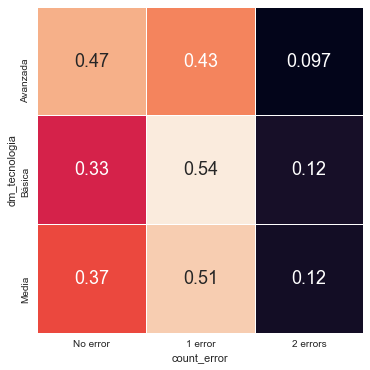

In [87]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)

### Barplot

In [88]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,dm_tecnologia,count_error,count
0,Avanzada,No error,205
1,Media,1 error,196
2,Avanzada,1 error,185
3,Media,No error,144
4,Media,2 errors,46
5,Básica,1 error,44
6,Avanzada,2 errors,42
7,Básica,No error,27
8,Básica,2 errors,10


<AxesSubplot:xlabel='count_error', ylabel='count'>

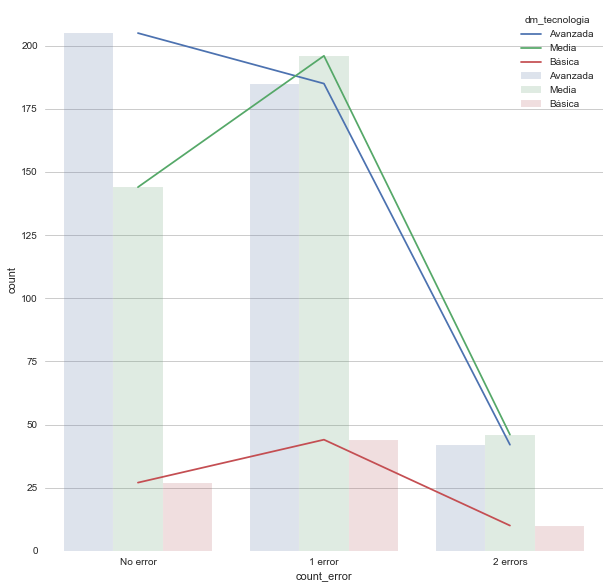

In [89]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax, alpha=0.2)

### Kruskal-Wallis H test

In [90]:
value_per_grp = data.groupby(col_var)['count_error'].apply(list)

In [91]:
scipy.stats.kruskal(*value_per_grp)

KruskalResult(statistic=9.810096478968196, pvalue=0.007409085663823835)

### Post-hoc: Dunn test

In [92]:
sp.posthoc_dunn(data, val_col='count_error', group_col=col_var, p_adjust = 'bonferroni')

,Avanzada,Básica,Media
Avanzada,1.000000,0.077748,0.014561
Básica,0.077748,1.000000,1.000000
Media,0.014561,1.000000,1.000000


## Analysis of 4 categories
Here I redo the analysis using the fourth categories created by María del Carmen

In [93]:
conditions = [
    (df['True news'] == 'Right') & (df['Fake news'] == 'Right'),
    (df['True news'] == 'Right') & (df['Fake news'] == 'Wrong'),
    (df['True news'] == 'Wrong') & (df['Fake news'] == 'Right'),
    (df['True news'] == 'Wrong') & (df['Fake news'] == 'Wrong'),
    ]

# create a list of the values we want to assign for each condition
values = ['TR-FR', 'TR-FW', 'TW-FR', 'TW-FW']
df['cat_tf_rw'] = np.select(conditions, values)

### Difference with age

In [94]:
col_var = 'recode_age'
data = df[[col_var, 'cat_tf_rw']]
data_count = pd.crosstab(data[col_var], data['cat_tf_rw'])
data_count

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
recode_age,,,,
<=18-34,95,68,38,26
35-54,188,113,99,53
>55,95,51,59,19


In [95]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 899


In [96]:
data_count_normalised = pd.crosstab(  df[col_var],df['cat_tf_rw'], normalize='index')
data_count_normalised

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
recode_age,,,,
<=18-34,0.418502,0.299559,0.167401,0.114537
35-54,0.415011,0.249448,0.218543,0.116998
>55,0.424107,0.227679,0.263393,0.084821


#### Heatmap

<AxesSubplot:xlabel='cat_tf_rw', ylabel='recode_age'>

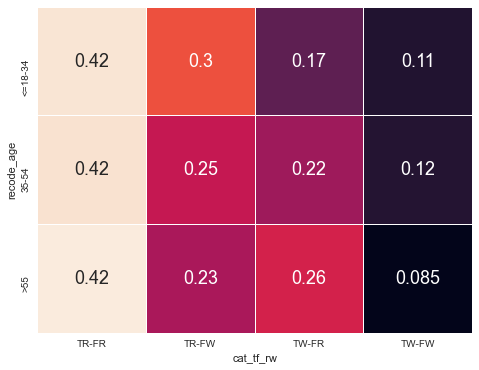

In [97]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)

#### Barplot

In [98]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_age,cat_tf_rw,count
0,35-54,TR-FR,188
1,35-54,TR-FW,113
2,35-54,TW-FR,99
3,<=18-34,TR-FR,95
4,>55,TR-FR,95
5,<=18-34,TR-FW,68
6,>55,TW-FR,59
7,35-54,TW-FW,53
8,>55,TR-FW,51
9,<=18-34,TW-FR,38


<AxesSubplot:xlabel='cat_tf_rw', ylabel='count'>

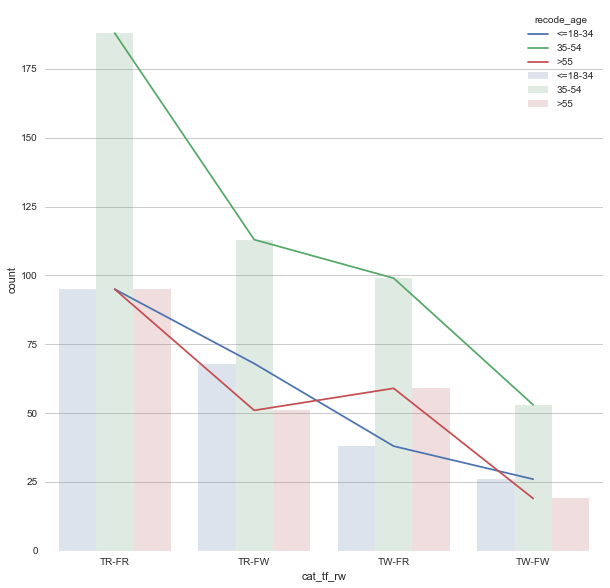

In [99]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax, alpha=0.2)

#### Chisquare of independence test

In [100]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 8.823129340240325, p-value: 0.18377221546411376



,recode_age,cat_tf_rw,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,<=18-34,TR-FR,0.012728,0.989845,1.000000,False,ns
1,<=18-34,TR-FW,1.710904,0.087099,1.000000,False,ns
2,<=18-34,TW-FR,-2.087710,0.036824,0.441888,False,ns
3,<=18-34,TW-FW,0.343303,0.731371,1.000000,False,ns
4,35-54,TR-FR,-0.191248,0.848332,1.000000,False,ns
5,35-54,TR-FW,-0.495971,0.619915,1.000000,False,ns
6,35-54,TW-FR,0.126426,0.899395,1.000000,False,ns
7,35-54,TW-FW,0.832649,0.405043,1.000000,False,ns
8,>55,TR-FR,0.208706,0.834678,1.000000,False,ns
9,>55,TR-FW,-1.144119,0.252574,1.000000,False,ns


### Difference with gender

In [101]:
col_var = 'dm_genero'
data = df[[col_var, 'cat_tf_rw']]
data_count = pd.crosstab(data[col_var], data['cat_tf_rw'])
data_count

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
dm_genero,,,,
Femenino,210,126,97,49
Masculino,168,106,99,49


In [102]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 899


In [103]:
data_count_normalised = pd.crosstab(  df[col_var],df['cat_tf_rw'], normalize='index')
data_count_normalised

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
dm_genero,,,,
Femenino,0.435685,0.261411,0.201245,0.101660
Masculino,0.398104,0.251185,0.234597,0.116114


#### Heatmap

<AxesSubplot:xlabel='cat_tf_rw', ylabel='dm_genero'>

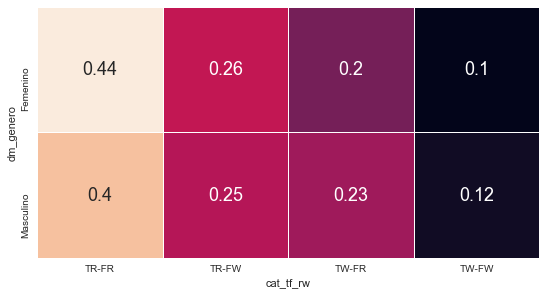

In [104]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)

#### Barplot

In [105]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,dm_genero,cat_tf_rw,count
0,Femenino,TR-FR,210
1,Masculino,TR-FR,168
2,Femenino,TR-FW,126
3,Masculino,TR-FW,106
4,Masculino,TW-FR,99
5,Femenino,TW-FR,97
6,Femenino,TW-FW,49
7,Masculino,TW-FW,49


<AxesSubplot:xlabel='cat_tf_rw', ylabel='count'>

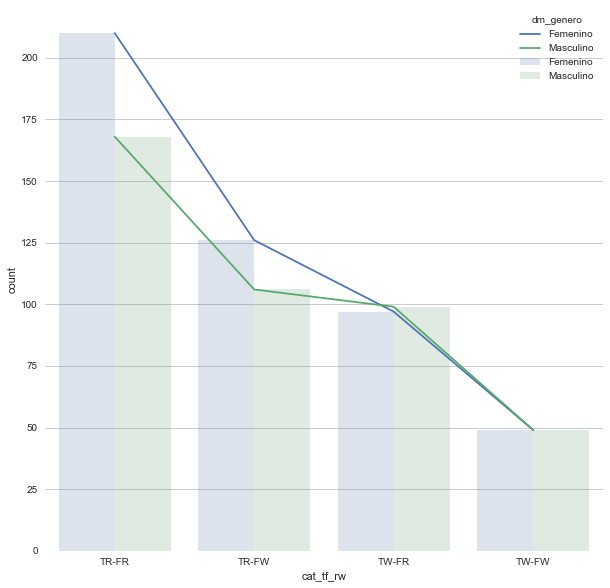

In [106]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax, alpha=0.2)

#### Chisquare of independence test

In [107]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 2.439659062341401, p-value: 0.4862947993740425



,dm_genero,cat_tf_rw,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,Femenino,TR-FR,1.142842,0.253104,1.0,False,ns
1,Femenino,TR-FW,0.351188,0.725448,1.0,False,ns
2,Femenino,TW-FR,-1.214075,0.224719,1.0,False,ns
3,Femenino,TW-FW,-0.697383,0.485563,1.0,False,ns
4,Masculino,TR-FR,-1.142842,0.253104,1.0,False,ns
5,Masculino,TR-FW,-0.351188,0.725448,1.0,False,ns
6,Masculino,TW-FR,1.214075,0.224719,1.0,False,ns
7,Masculino,TW-FW,0.697383,0.485563,1.0,False,ns


### Difference with Uni vs Non Uni

In [108]:
col_var = 'recode_education'
data = df[[col_var, 'cat_tf_rw']]
data_count = pd.crosstab(data[col_var], data['cat_tf_rw'])
data_count

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
recode_education,,,,
No university studies,148,123,97,50
University studies,229,109,98,48


In [109]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 899


In [110]:
data_count_normalised = pd.crosstab(  df[col_var],df['cat_tf_rw'], normalize='index')
data_count_normalised

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
recode_education,,,,
No university studies,0.354067,0.294258,0.232057,0.119617
University studies,0.473140,0.225207,0.202479,0.099174


#### Heatmap

<AxesSubplot:xlabel='cat_tf_rw', ylabel='recode_education'>

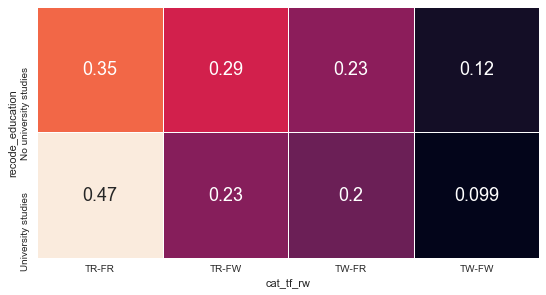

In [111]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)

#### Barplot

In [112]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_education,cat_tf_rw,count
0,University studies,TR-FR,229
1,No university studies,TR-FR,148
2,No university studies,TR-FW,123
3,University studies,TR-FW,109
4,University studies,TW-FR,98
5,No university studies,TW-FR,97
6,No university studies,TW-FW,50
7,University studies,TW-FW,48


<AxesSubplot:xlabel='cat_tf_rw', ylabel='count'>

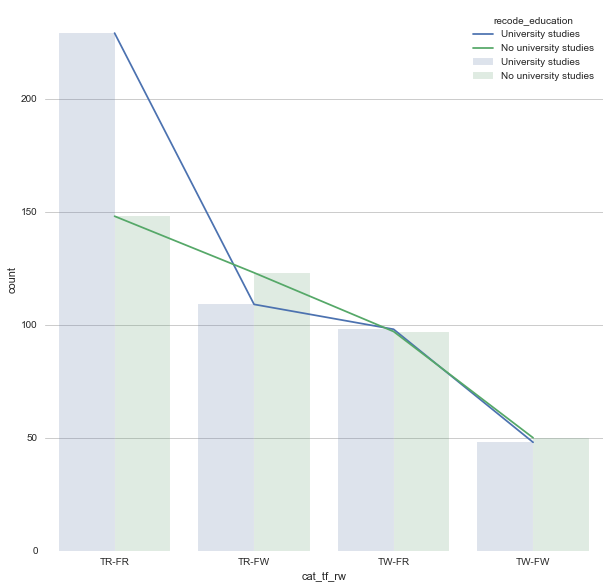

In [113]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax, alpha=0.2)

#### Chisquare of independence test

In [114]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 13.537164230420004, p-value: 0.0036078930491258896



,recode_education,cat_tf_rw,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,No university studies,TR-FR,-3.615588,0.000300,0.002397,True,**
1,No university studies,TR-FW,2.365960,0.017983,0.143867,False,ns
2,No university studies,TW-FR,1.076111,0.281878,1.000000,False,ns
3,No university studies,TW-FW,0.983857,0.325186,1.000000,False,ns
4,University studies,TR-FR,3.615588,0.000300,0.002397,True,**
5,University studies,TR-FW,-2.365960,0.017983,0.143867,False,ns
6,University studies,TW-FR,-1.076111,0.281878,1.000000,False,ns
7,University studies,TW-FW,-0.983857,0.325186,1.000000,False,ns


### Difference with political parties

In [115]:
col_var = 'recode_politics'
data = df[[col_var, 'cat_tf_rw']]
data_count = pd.crosstab(data[col_var], data['cat_tf_rw'])
data_count

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
recode_politics,,,,
Centro,49,41,44,14
Derecha,63,53,36,26
Izquierda,184,79,70,43


In [116]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 899


In [117]:
data_count_normalised = pd.crosstab(  df[col_var],df['cat_tf_rw'], normalize='index')
data_count_normalised

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
recode_politics,,,,
Centro,0.331081,0.277027,0.297297,0.094595
Derecha,0.353933,0.297753,0.202247,0.146067
Izquierda,0.489362,0.210106,0.186170,0.114362


#### Heatmap

<AxesSubplot:xlabel='cat_tf_rw', ylabel='recode_politics'>

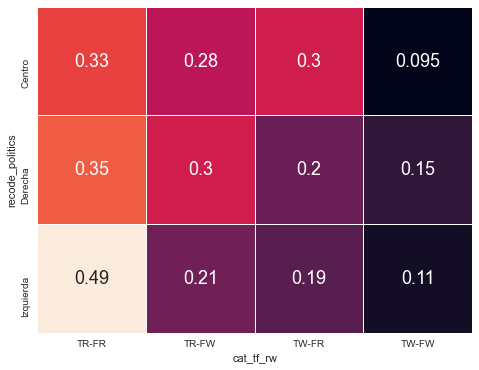

In [118]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)

#### Barplot

In [119]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_politics,cat_tf_rw,count
0,Izquierda,TR-FR,184
1,Izquierda,TR-FW,79
2,Izquierda,TW-FR,70
3,Derecha,TR-FR,63
4,Derecha,TR-FW,53
5,Centro,TR-FR,49
6,Centro,TW-FR,44
7,Izquierda,TW-FW,43
8,Centro,TR-FW,41
9,Derecha,TW-FR,36


<AxesSubplot:xlabel='cat_tf_rw', ylabel='count'>

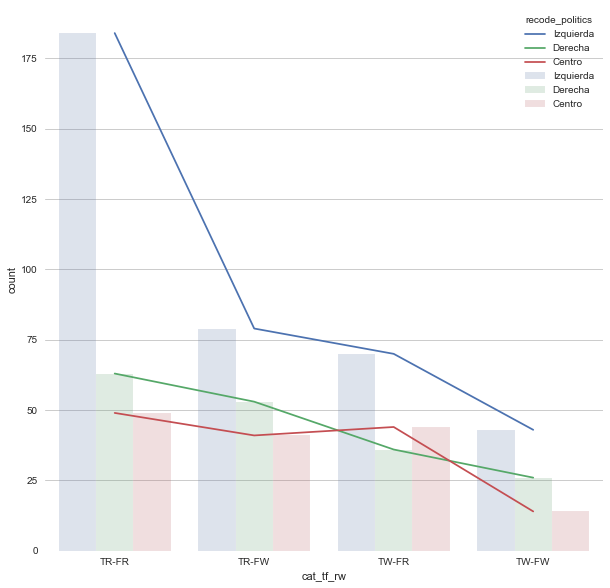

In [120]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax, alpha=0.2)

#### Chisquare of independence test

In [121]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 21.578198938160135, p-value: 0.0014434392886938613



,recode_politics,cat_tf_rw,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,Centro,TR-FR,-2.511676,0.012016,0.144191,False,ns
1,Centro,TR-FW,0.972044,0.331029,1.000000,False,ns
2,Centro,TW-FR,2.793749,0.005210,0.062521,False,ns
3,Centro,TW-FW,-1.002598,0.316055,1.000000,False,ns
4,Derecha,TR-FR,-2.117664,0.034204,0.410442,False,ns
5,Derecha,TR-FW,1.838804,0.065944,0.791328,False,ns
6,Derecha,TW-FR,-0.430533,0.666808,1.000000,False,ns
7,Derecha,TW-FW,1.331184,0.183128,1.000000,False,ns
8,Izquierda,TR-FR,3.901487,0.000096,0.001147,True,**
9,Izquierda,TR-FW,-2.399018,0.016439,0.197269,False,ns


### Difference with Religious belief

In [122]:
col_var = 'recode_religion'
data = df[[col_var, 'cat_tf_rw']]
data_count = pd.crosstab(data[col_var], data['cat_tf_rw'])
data_count2 = pd.crosstab( data['cat_tf_rw'], data[col_var])

data_count

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
recode_religion,,,,
Atheists/Agnostics,179,84,58,32
Believers,160,126,114,59


In [123]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 899


In [124]:
data_count_normalised = pd.crosstab(  df[col_var],df['cat_tf_rw'], normalize='index')
data_count_normalised

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
recode_religion,,,,
Atheists/Agnostics,0.507082,0.23796,0.164306,0.090652
Believers,0.348584,0.27451,0.248366,0.128540


#### Heatmap

<AxesSubplot:xlabel='cat_tf_rw', ylabel='recode_religion'>

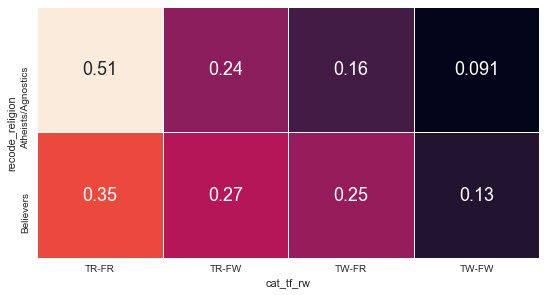

In [125]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)

#### Barplot

In [126]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_religion,cat_tf_rw,count
0,Atheists/Agnostics,TR-FR,179
1,Believers,TR-FR,160
2,Believers,TR-FW,126
3,Believers,TW-FR,114
4,Atheists/Agnostics,TR-FW,84
5,Believers,TW-FW,59
6,Atheists/Agnostics,TW-FR,58
7,Atheists/Agnostics,TW-FW,32


<AxesSubplot:xlabel='cat_tf_rw', ylabel='count'>

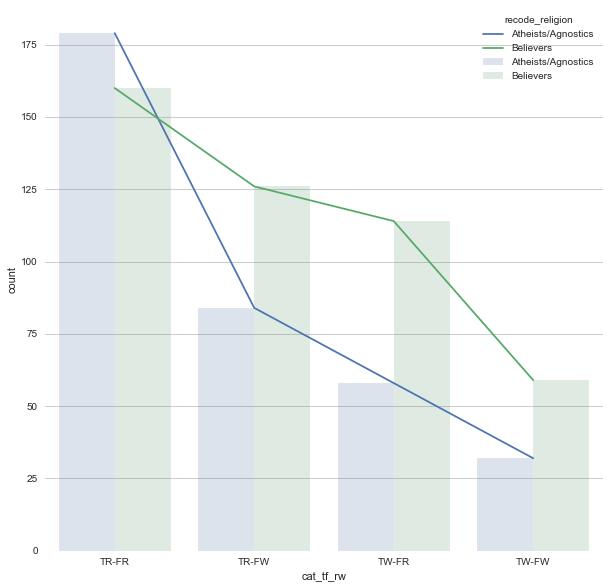

In [127]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax, alpha=0.2)

#### Chisquare of independence test

In [128]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 22.250174721729586, p-value: 5.7861397632667014e-05



,recode_religion,cat_tf_rw,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,Atheists/Agnostics,TR-FR,4.540104,0.000006,0.000045,True,****
1,Atheists/Agnostics,TR-FW,-1.179084,0.238365,1.000000,False,ns
2,Atheists/Agnostics,TW-FR,-2.906078,0.003660,0.029279,True,*
3,Atheists/Agnostics,TW-FW,-1.696655,0.089762,0.718095,False,ns
4,Believers,TR-FR,-4.540104,0.000006,0.000045,True,****
5,Believers,TR-FW,1.179084,0.238365,1.000000,False,ns
6,Believers,TW-FR,2.906078,0.003660,0.029279,True,*
7,Believers,TW-FW,1.696655,0.089762,0.718095,False,ns


### Difference with technological knowledge

In [129]:
col_var = 'dm_tecnologia'
data = df[[col_var, 'cat_tf_rw']]
data_count = pd.crosstab(data[col_var],  data['cat_tf_rw'])
data_count2 = pd.crosstab( data['cat_tf_rw'], data[col_var])
data_count

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
dm_tecnologia,,,,
Avanzada,205,104,81,42
Básica,27,21,23,10
Media,144,105,91,46


In [130]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 899


In [131]:
data_count_normalised = pd.crosstab(  df[col_var],df['cat_tf_rw'], normalize='index')
data_count_normalised

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
dm_tecnologia,,,,
Avanzada,0.474537,0.240741,0.187500,0.097222
Básica,0.333333,0.259259,0.283951,0.123457
Media,0.373057,0.272021,0.235751,0.119171


#### Heatmap

<AxesSubplot:xlabel='cat_tf_rw', ylabel='dm_tecnologia'>

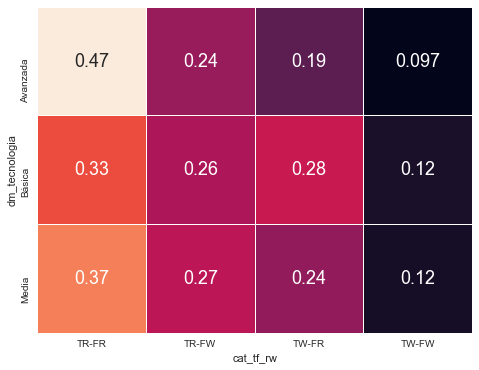

In [132]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)

#### Barplot

In [133]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,dm_tecnologia,cat_tf_rw,count
0,Avanzada,TR-FR,205
1,Media,TR-FR,144
2,Media,TR-FW,105
3,Avanzada,TR-FW,104
4,Media,TW-FR,91
5,Avanzada,TW-FR,81
6,Media,TW-FW,46
7,Avanzada,TW-FW,42
8,Básica,TR-FR,27
9,Básica,TW-FR,23


<AxesSubplot:xlabel='cat_tf_rw', ylabel='count'>

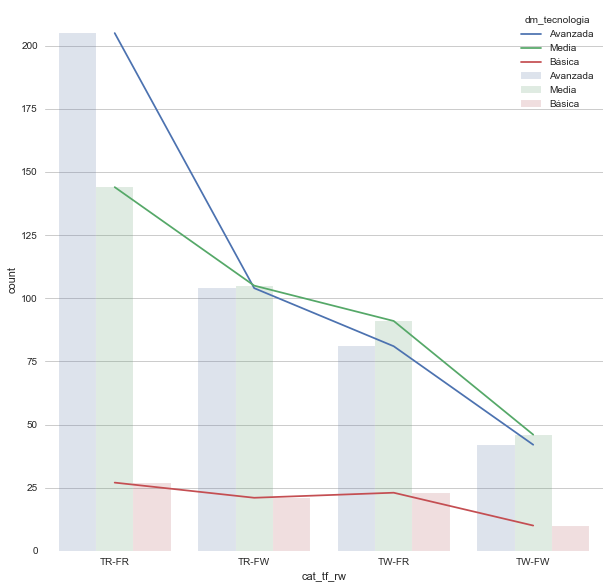

In [134]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax, alpha=0.2)

#### Chisquare of independence test

In [135]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 12.441678438083445, p-value: 0.05281042354384135



,dm_tecnologia,cat_tf_rw,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,Avanzada,TR-FR,3.291126,0.000998,0.011974,True,*
1,Avanzada,TR-FW,-0.997922,0.318317,1.000000,False,ns
2,Avanzada,TW-FR,-2.057690,0.039620,0.475438,False,ns
3,Avanzada,TW-FW,-1.090752,0.275382,1.000000,False,ns
4,Básica,TR-FR,-1.624109,0.104353,1.000000,False,ns
5,Básica,TR-FW,0.073941,0.941058,1.000000,False,ns
6,Básica,TW-FR,1.534811,0.124830,1.000000,False,ns
7,Básica,TW-FW,0.437368,0.661844,1.000000,False,ns
8,Media,TR-FR,-2.382477,0.017197,0.206359,False,ns
9,Media,TR-FW,0.964496,0.334797,1.000000,False,ns


## Analysis of actions

In [136]:
## 
var_actions_f = ['faf_compartira_familia_amigos', 'faf_publicara_redes', 'faf_consultara_fuentes', 'faf_aplicara_aprendido', 'faf_no_accion']
var_actions_t = ['taf_compartira_familia_amigos', 'taf_publicara_redes', 'taf_consultara_fuentes', 'taf_aplicara_aprendido', 'taf_no_accion']
var_actions = var_actions_f + var_actions_t
data = df[['True news', 'Fake news', *var_actions]]
#data = data.melt(id_vars=[*var_actions])


data['total_checked_f'] = data.loc[:, var_actions_f].isin([True]).sum(axis=1)
data['total_checked_t'] = data.loc[:, var_actions_t].isin([True]).sum(axis=1)



<ipython-input-136-dfe5c64aefc2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['total_checked_f'] = data.loc[:, var_actions_f].isin([True]).sum(axis=1)
<ipython-input-136-dfe5c64aefc2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['total_checked_t'] = data.loc[:, var_actions_t].isin([True]).sum(axis=1)


In [137]:
data[(data['total_checked_f'] > 1) & (data['faf_no_accion'] == True)][['total_checked_f', *var_actions_f]]

,total_checked_f,faf_compartira_familia_amigos,faf_publicara_redes,faf_consultara_fuentes,faf_aplicara_aprendido,faf_no_accion
92,2,False,False,False,True,True
94,2,False,False,True,False,True
259,2,False,False,True,False,True
344,2,False,False,True,False,True
534,2,False,False,True,False,True
588,2,False,False,True,False,True
670,2,False,False,True,False,True
673,2,False,False,True,False,True
742,2,False,False,False,True,True
779,2,False,False,True,False,True


In [138]:
data[(data['total_checked_t'] > 1) & (data['taf_no_accion'] == True)][['total_checked_t', *var_actions_t]]

,total_checked_t,taf_compartira_familia_amigos,taf_publicara_redes,taf_consultara_fuentes,taf_aplicara_aprendido,taf_no_accion
79,2,False,False,True,False,True
94,2,False,False,True,False,True
238,2,False,False,False,True,True
327,3,False,False,True,True,True
332,2,False,False,False,True,True
367,2,False,False,False,True,True
394,2,True,False,False,False,True
450,3,False,False,True,True,True
508,2,False,False,True,False,True
516,2,False,False,False,True,True


In [139]:
# Does the people that are wrong, will more often share news with their family than people that are right
# Does fake news will be more often shared than true news. 
var_actions_f = ['faf_compartira_familia_amigos']
var_actions_t = ['taf_compartira_familia_amigos']
var_actions = var_actions_f + var_actions_t

data = df[['True news', 'Fake news', *var_actions]]
data = data.melt(id_vars=[*var_actions])
data = data.rename(columns={'variable': 'type_news', 'value': 'answer'})
data = data[data['answer'] == 'Wrong']
data.groupby('type_news').agg('mean')

,faf_compartira_familia_amigos,taf_compartira_familia_amigos
type_news,,
Fake news,0.378788,0.257576
True news,0.190476,0.112245


# Sources

## Packages

 * mord: [https://github.com/fabianp/mord](https://github.com/fabianp/mord)
     >Pedregosa, Fabian, Francis Bach, and Alexandre Gramfort. "On the consistency of ordinal regression methods." The Journal of Machine Learning Research 18.1 (2017) JMLR.
 * pingouin: [https://pingouin-stats.org/](https://pingouin-stats.org/)
     > Vallat, R. (2018). Pingouin: statistics in Python. Journal of Open Source Software, 3(31), 1026, https://doi.org/10.21105/joss.01026
 * statsmodels: [https://www.statsmodels.org](https://www.statsmodels.org)
    > @inproceedings{seabold2010statsmodels,title={statsmodels: Econometric and statistical modeling with python}, author={Seabold, Skipper and Perktold, Josef}, booktitle={9th Python in Science Conference},year={2010},}
 * scipy: [https://www.scipy.org](https://www.scipy.org)
     > @ARTICLE{2020SciPy-NMeth, author  = {Virtanen, Pauli and Gommers, Ralf and Oliphant, Travis E. and Haberland, Matt and Reddy, Tyler and Cournapeau, David and Burovski, Evgeni and Peterson, Pearu and Weckesser, Warren and Bright, Jonathan and {van der Walt}, St{\'e}fan J. and Brett, Matthew and Wilson, Joshua and Millman, K. Jarrod and Mayorov, Nikolay and Nelson, Andrew R. J. and Jones, Eric and Kern, Robert and Larson, Eric and Carey, C J and Polat, {\.I}lhan and Feng, Yu and Moore, Eric W. and {VanderPlas}, Jake and Laxalde, Denis and Perktold, Josef and Cimrman, Robert and Henriksen, Ian and Quintero, E. A. and Harris, Charles R. and Archibald, Anne M. and Ribeiro, Ant{\^o}nio H. and Pedregosa, Fabian and {van Mulbregt}, Paul and {SciPy 1.0 Contributors}},title   = {{{SciPy} 1.0: Fundamental Algorithms for Scientific Computing in Python}}, journal = {Nature Methods}, year    = {2020}, volume  = {17}, pages   = {261--272}, adsurl  = {https://rdcu.be/b08Wh}, doi     = {10.1038/s41592-019-0686-2},}
 * scikit-learn: [https://scikit-learn.org](https://scikit-learn.org)
     > Fabian Pedregosa, Gaël Varoquaux, Alexandre Gramfort, Vincent Michel, Bertrand Thirion, Olivier Grisel, Mathieu Blondel, Peter Prettenhofer, Ron Weiss, Vincent Dubourg, Jake Vanderplas, Alexandre Passos, David Cournapeau, Matthieu Brucher, Matthieu Perrot, Édouard Duchesnay. Scikit-learn: Machine Learning in Python, Journal of Machine Learning Research, 12, 2825-2830 (2011) (publisher link)

## Articles

*   Bürkner, P.-C., & Vuorre, M. (2019). Ordinal Regression Models in Psychology: A Tutorial. Advances in Methods and Practices in Psychological Science, 77–101. https://doi.org/10.1177/2515245918823199